
4)
Es werden zwei Listen mit 1000 zufälligen Mustern erstellt. In die erste Liste werden die verschiedenen Vektoren zum Training eingefügt.
Die zweite Liste enthält jeweils die richtigen Ergebnisse passend zur ersten Liste mit den Vektoren (1, wenn der Vektor dem gesuchten Pattern entspricht und 0 wenn es ein anderer Vektor ist).

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import random

good_patterns = [[1, 0, 0, 1]]
training_data_length = 1000

# gibt eine Liste mit Länge `length` von zufälligen patterns mit Länge `pattern_length` aus
# optional wird statt eines zufälligen Patterns eins aus dem `pattern_to_inject` array 
# mit einer Wahrscheinlichkeit von `share` eingefügt
def getTrainingData(length, pattern_length, patterns_to_inject=None, share=0.3):
    training_data = np.array([np.array([0, 1]).repeat(pattern_length / 2)] * length)
    
    for i, pattern in enumerate(training_data):
        
        if patterns_to_inject and np.random.rand() < share:
            training_data[i] = np.copy(random.choice(patterns_to_inject))
        else: 
            np.random.shuffle(pattern) # es wird "in Place" geshuffelt, also das Pattern, das bereits Teil des `training_data` arrays ist
    
    return training_data


def getCorrectResults(patterns, good_patterns):
    return np.array([1 if list(pattern) in good_patterns else 0 for pattern in patterns])

training_data = getTrainingData(training_data_length, pattern_length=4)
correct_results_training_data = getCorrectResults(training_data, good_patterns)

Jede Epoche wird von Keras automatisch in batches mit einer default Länge von 32 Aufgaben aufgeteilt. Um genauere Trainingsdaten nach jeder Batch zu erhalten, wird die Folgende Klasse an Keras in der `fit` Funktion als callback übergeben. Keras wird dann nach jeder Batch `TrainingHistory.on_batch_end` aufrufen und den Loss und die Accuracy übergeben.


In [13]:
# eine Instanz der Klasse wird and die Keras `fit` Funktion als callback übergeben um die Trainingsdaten zu erhalten
class TrainingHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))

    def plot(self):
        plt.figure(figsize=(12, 8))

        # Loss
        plt.subplot(2, 1, 1)
        plt.plot(self.losses, label="Loss")
        plt.yscale("log")
        plt.ylabel("Loss")
        plt.xlabel("Batch")
        plt.title("Loss by Batch")

        # Accuracy
        plt.subplot(2, 1, 2)
        plt.plot(self.accuracies, label="accuracy")

        plt.ylabel("Accuracy")
        plt.xlabel("Batch")
        plt.title("Accuracy by Batch")

        plt.tight_layout()
        plt.show()


Das neuronale Netz aus Aufgabe 3 wird mithilfe von Keras implementiert.
Die Flag use_extra_layer wird später in Aufgabe 4d) wichtig, bleibt aber bis dahin deaktiviert.

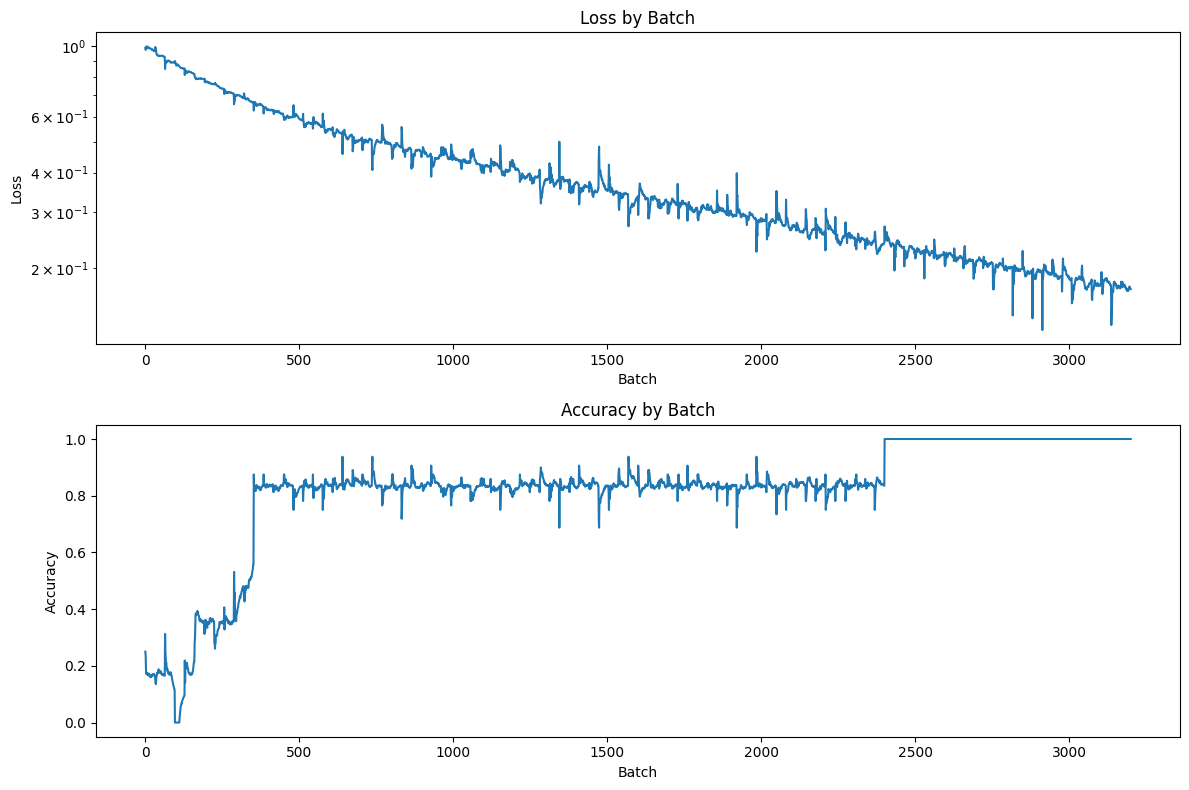

first_perfect_batch=2400, translates to epoche 76.8
Weights:
Layer 0:
Weight 0: [0.9171701]
Weight 1: [-1.7117254]
Weight 2: [-1.3636588]
Weight 3: [0.88335466]
Layer 1:
Weight 0: -1.3125089406967163


In [14]:
# für Aufgabe 4d), wir variieren die Anzahl der Layer
use_extra_layer = False
epochs = 5 if use_extra_layer else 100

NN = keras.Sequential()
NN.add(keras.Input(shape=(4,)))
if use_extra_layer:
    NN.add(keras.layers.Dense(128, activation="relu"))
NN.add(keras.layers.Dense(1, activation="sigmoid"))    # sigmoid(x) = 1 / (1 + exp(-x)) in diesem Fall

NN.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

training_history = TrainingHistory()
NN.fit(training_data, correct_results_training_data, epochs=epochs, callbacks=[training_history], verbose=0, batch_size=32)
training_history.plot()

try:
    first_perfect_batch = np.where(np.array(training_history.accuracies) == 1.0)[0][0]
    print(f"{first_perfect_batch=}, translates to epoche {32 / training_data_length * first_perfect_batch}")
except IndexError:
    print("no perfect batch found")

# Die weights sollen nur ausgegeben werden, wenn wir nicht die Extra Layer verwenden, da es sonst zu unübersichtlich wird.
if not use_extra_layer:
    weights = NN.get_weights()
    print("Weights:")
    for i, layer_weights in enumerate(weights):
        print(f"Layer {i}:")
        for j, weight in enumerate(layer_weights):
            print(f"Weight {j}: {weight}")

Es ist erkennbar, dass es ohne die ExtraLayer, die wir in der folgenden Aufgabe ergänzen wollen, zwischen 6 und 80 Epochen nötig sind, bis unser Neuronales Netz eine perfekte Vorhersage treffen kann. Die weights können jetzt auch negativ werden.

4.d) Es wird eine extra Layer eingefügt mit 128 Neuronen, dafür muss nur der Parameter use_exra_layer auf True gesetzt werden.
Da wir weniger Trainingszeit brauchen, setzen wir die Anzahl der Trainingsepochen auf 5.

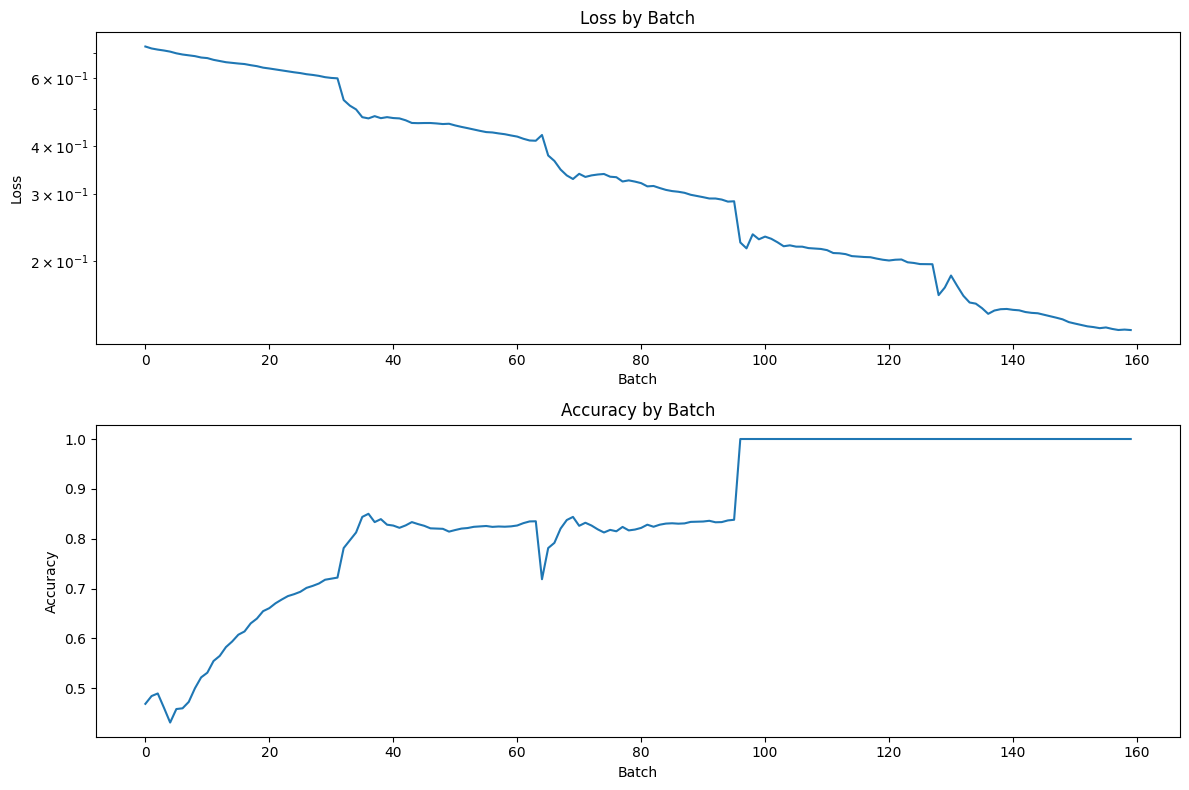

first_perfect_batch=96, translates to epoche 3.072


In [15]:
# KOPIE DES CODES VON OBEN MIT use_extra_layer = True

# für Aufgabe 4d), wir variieren die Anzahl der Layer
use_extra_layer = True
epochs = 5 if use_extra_layer else 100

NN = keras.Sequential()
NN.add(keras.Input(shape=(4,)))
if use_extra_layer:
    NN.add(keras.layers.Dense(128, activation="relu"))
NN.add(keras.layers.Dense(1, activation="sigmoid"))    # sigmoid(x) = 1 / (1 + exp(-x)) here

NN.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

training_history = TrainingHistory()
NN.fit(training_data, correct_results_training_data, epochs=5, callbacks=[training_history], verbose=0, batch_size=32)
training_history.plot()

try:
    first_perfect_batch = np.where(np.array(training_history.accuracies) == 1.0)[0][0]
    print(f"{first_perfect_batch=}, translates to epoche {32 / training_data_length * first_perfect_batch}")
except IndexError:
    print("no perfect batch found")

Es ist zu erkennen, dass die Anzahl der benötigten Epochen durch die extra Layer auf ca 3 deutlich reduziert wurde.

Jetzt wird das NN mit neuen, zufällig generierten Patterns getestet. 

In [16]:
test_data = getTrainingData(training_data_length, pattern_length=4)

# NN.predict returns an array with shape=(trainging_data_length = 1000, output_neurons = 1) 
# so we flatten it to get a 1D array with our predictions
results_on_test_data = NN.predict(test_data).flatten() 
correct_results_test_data = getCorrectResults(test_data, good_patterns)

all_correct = np.array_equal(correct_results_test_data, np.round(results_on_test_data))
max_difference = max(abs(results_on_test_data - correct_results_test_data))
print(f"all test data correct, when rounded: {all_correct}")
print(f"maximum difference from correct result: {max_difference}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
all test data correct, when rounded: True
maximum difference from correct result: 0.26149845123291016


Der Test zeigt, dass alle 1000 pattern richtig zugeordnet wurden.

Aufgabe 4e
Es werden mehr Trainingsaufgaben benötigt, da im Folgenden ein 8x8 Schachbrettmuster erkannt werden soll.
Das NN soll sowohl das Muster mit einem weißen Feld auf a1 und einem schwarzen Feld auf a1 als richtig erkennen.

In [17]:
good_patterns = [
    list(np.array(list(zip(np.ones(32), np.zeros(32)))).flatten()),
    list(np.array(list(zip(np.zeros(32), np.ones(32)))).flatten())
]

training_data_length = 20_000

# da das gesuchte Pattern bei rein zufälligem Erzeugen der Trainingsdaten mit hoher Wahrscheinlichkeit gar nicht vorkommen würde,
# injezieren wir künstlich die gesuchten Patterns mit einem Anteil von ca 30 %
training_data = getTrainingData(training_data_length, pattern_length=64, patterns_to_inject=good_patterns, share=0.3)
correct_results_training_data = getCorrectResults(training_data, good_patterns)

Das verwendete NN hat eine Input Layer mit 64 Neuronen für jedes Feld, zwei Hidden Layer mit 32 beziehungsweise 16 Neuronen und wieder eine Output Layer mit genau einem Neuron und der Sigmoid Aktivierungsfunktion.

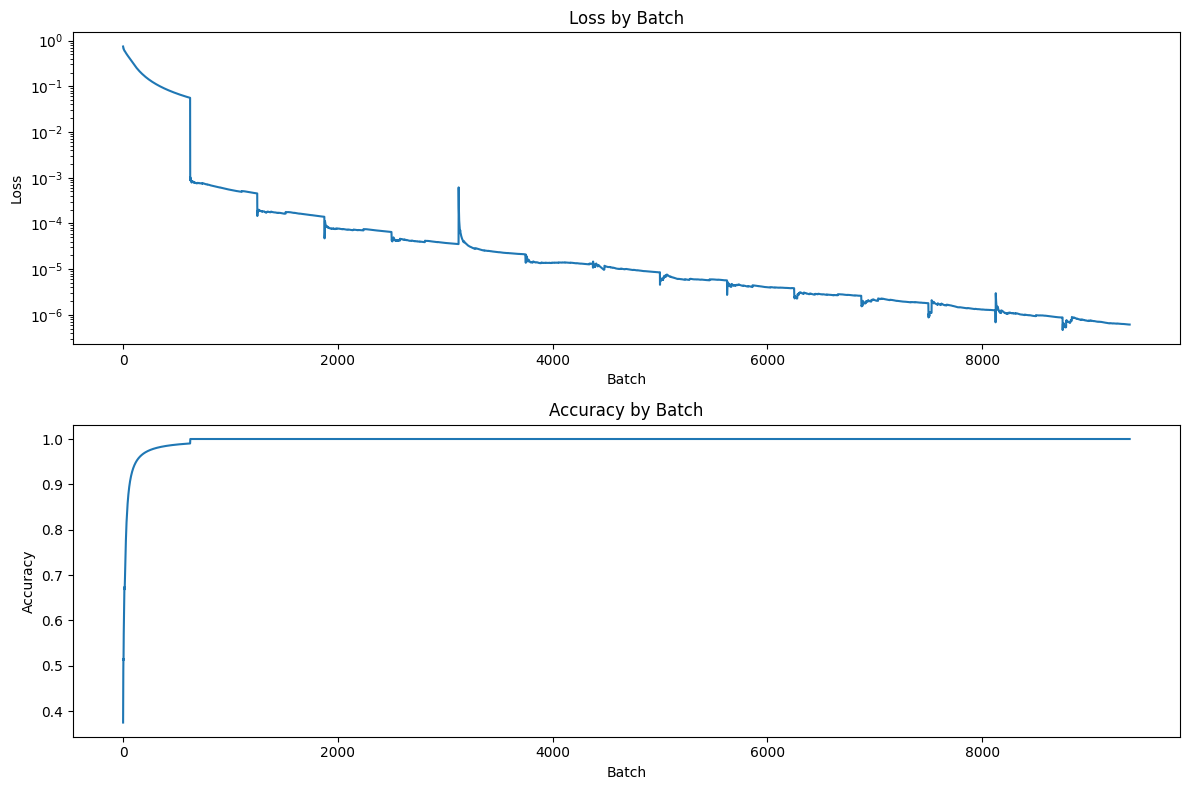

In [18]:
NN = keras.Sequential()
NN.add(keras.Input(shape=(64,)))
NN.add(keras.layers.Dense(32, activation="relu"))
NN.add(keras.layers.Dense(16, activation="relu"))
NN.add(keras.layers.Dense(1, activation="sigmoid"))

NN.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

training_history = TrainingHistory()
NN.fit(training_data, correct_results_training_data, epochs=15, callbacks=[training_history], verbose=0)
training_history.plot()

In [19]:
# für die Testdaten reicht es theoretisch wenn wir beide richtigen Patterns einmal testen, daher injezieren wir die 
# gesuchten Patterns jetzt nur mit einem Anteil von ca 1%
test_data = getTrainingData(length=500_000, pattern_length=64, patterns_to_inject=good_patterns, share=0.01)

results_on_test_data = NN.predict(test_data).flatten()
correct_results_test_data = getCorrectResults(test_data, good_patterns)

all_correct = np.array_equal(correct_results_test_data, np.round(results_on_test_data))
max_difference = max(abs(results_on_test_data - correct_results_test_data))

print(f"all test data correct, when rounded: {all_correct}")
print(f"maximum difference from correct result: {max_difference}")

# Es wird noch ein Pattern, das beinahe identisch zu einem der gesuchten Patterns ist, getestet: 
almost_good_pattern = np.copy(good_patterns[0])
almost_good_pattern[0], almost_good_pattern[1] = almost_good_pattern[1], almost_good_pattern[0]

result_for_almost_good_pattern = NN.predict(np.array([almost_good_pattern], dtype=int)).flatten()[0]

print(f"{almost_good_pattern=}\n{result_for_almost_good_pattern=}")

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 11s 671us/step
all test data correct, when rounded: True
maximum difference from correct result: 0.02473207749426365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
almost_good_pattern=array([0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])
result_for_almost_good_pattern=0.99998665


Es werden zwar alle 500_000 zufälligen Patterns richtig zugeordnet, dass NN erkennt allerdings ein nahezu perfektes Schachbrettmuster mit nur zwei vertauschten Feldern fälschlicherweise als richtig. Wir gehen davon aus, dass für ein perfektes NN deutlich mehr Training von Nöten ist.